In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from statistics import mean
import scanorama
from anndata import AnnData as ad

In [2]:
# set directory
sample_dir = "/beegfs/scratch/ric.cosr/ric.cosr/DellabonaP/CosMX/5_Raw_data/R5630_Slide3"

In [3]:
#load Cosmx raw data
adata = sq.read.nanostring(
    path=sample_dir,
    counts_file="R5630_Slide3_exprMat_file.csv",
    meta_file="R5630_Slide3_metadata_file.csv",
    fov_file="R5630_Slide3_fov_positions_file.csv",
)

In [4]:
adata.obs["Idents"] =  adata.obs_names

In [5]:
adata.shape

(53926, 979)

In [6]:
list(adata.obs.columns)

['fov',
 'Area',
 'AspectRatio',
 'CenterX_global_px',
 'CenterY_global_px',
 'Width',
 'Height',
 'Mean.MembraneStain',
 'Max.MembraneStain',
 'Mean.PanCK',
 'Max.PanCK',
 'Mean.CD68',
 'Max.CD68',
 'Mean.CD3',
 'Max.CD3',
 'Mean.DAPI',
 'Max.DAPI',
 'cell_ID',
 'Idents']

In [7]:
#The percentage of unassigned “NegPrb” transcripts can be calculated from the calculated qc metrics. 
#This can later be used to estimate false discovery rate.
adata.var["NegPrb"] = adata.var_names.str.startswith("NegPrb")
sc.pp.calculate_qc_metrics(adata, qc_vars=["NegPrb"], inplace=True)

In [8]:
NegPrb =adata.var["NegPrb"]

In [9]:
#how many negative probes? 19
sum(NegPrb) 
#979 -19 = 960

19

In [10]:
adata.obs["total_counts_NegPrb"].sum() / adata.obs["total_counts"].sum() * 100

0.25727909735669

<Axes: title={'center': 'Transcripts per FOV'}, xlabel='total_counts', ylabel='Count'>

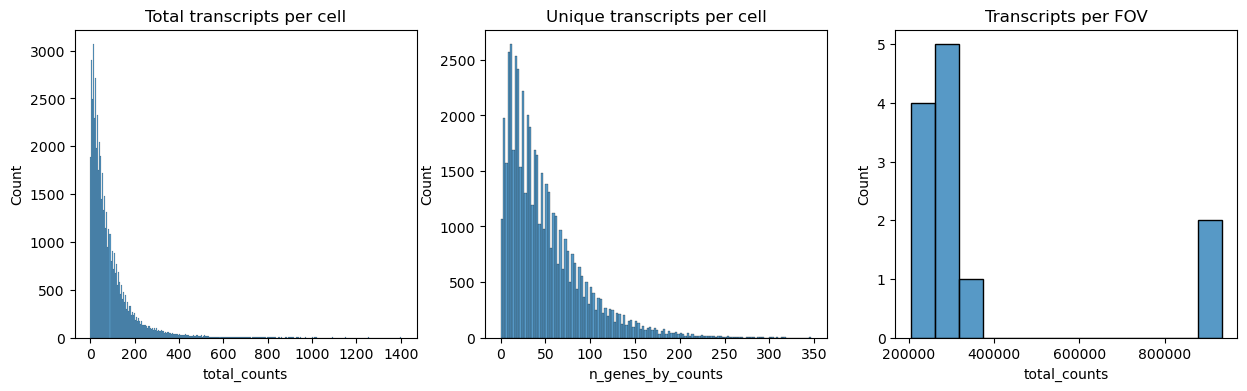

In [11]:
#total transcripts per cell, unique transcripts per cell and transcripts per FOV.
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].set_title("Total transcripts per cell")
sns.histplot(
    adata.obs["total_counts"],
    kde=False,
    ax=axs[0],
)

axs[1].set_title("Unique transcripts per cell")
sns.histplot(
    adata.obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
)

axs[2].set_title("Transcripts per FOV")
sns.histplot(
    adata.obs.groupby("fov").sum()["total_counts"],
    kde=False,
    ax=axs[2],
)

<Axes: title={'center': 'MembraneStain'}, xlabel='Mean.MembraneStain', ylabel='Count'>

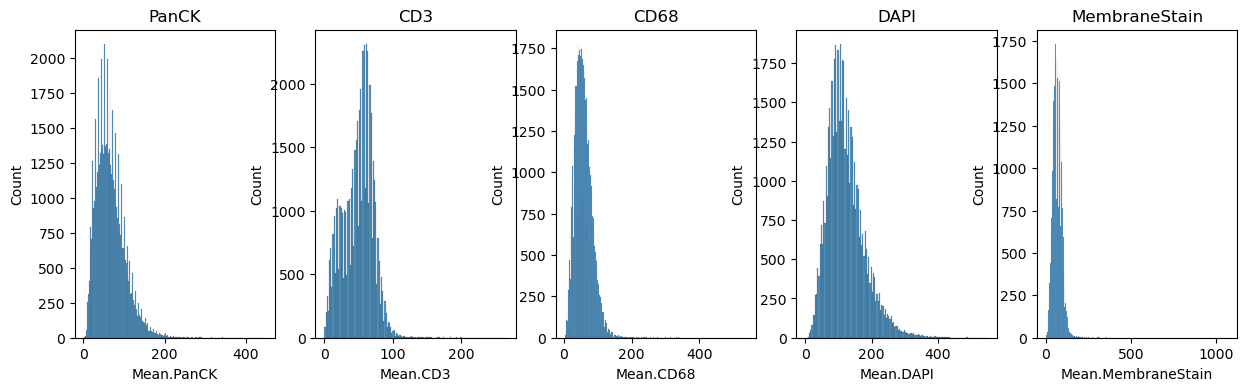

In [12]:
#The dataset also contains immunofluorescence data. It can be read from adata.obs
fig, axs = plt.subplots(1, 5, figsize=(15, 4))


axs[0].set_title("PanCK")
sns.histplot(
    adata.obs["Mean.PanCK"],
    kde=False,
    ax=axs[0],
)

axs[1].set_title("CD3")
sns.histplot(
    adata.obs["Mean.CD3"],
    kde=False,
    ax=axs[1],
)

axs[2].set_title("CD68")
sns.histplot(
    adata.obs["Mean.CD68"],
    kde=False,
    ax=axs[2],
)

axs[3].set_title("DAPI")
sns.histplot(
    adata.obs["Mean.DAPI"],
    kde=False,
    ax=axs[3],
)

axs[4].set_title("MembraneStain")
sns.histplot(
    adata.obs["Mean.MembraneStain"],
    kde=False,
    ax=axs[4],
)

In [13]:
adata.var_names_make_unique()
#adata.var["mt"] = adata.var_names.str.startswith("mt-")
#sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

In [14]:
#load seurat integrated object preprocessed by nanostring
adata_seurat = sc.read_h5ad("../../CosMx.h5ad")

In [15]:
list(adata_seurat.obs)

['orig.ident',
 'nCount_Nanostring',
 'nFeature_Nanostring',
 'cell_ID',
 'fov',
 'Area',
 'AspectRatio',
 'Width',
 'Height',
 'Mean.CD298',
 'Max.CD298',
 'Mean.PanCK',
 'Max.PanCK',
 'Mean.CD68',
 'Max.CD68',
 'Mean.CD3',
 'Max.CD3',
 'Mean.DAPI',
 'Max.DAPI',
 'Slide_name',
 'Run_name',
 'ISH.concentration',
 'ALPHA',
 'tissue',
 'Run_Slide_name',
 'slide_ID_numeric',
 'Run_Tissue_name',
 'log10totalcounts',
 'IFcolor',
 'nb_clus',
 'leiden_clus',
 'nclust',
 'id']

In [16]:
adata_seurat.obs.fov

R5630.Slide2_1_1         1
R5630.Slide2_2_1         1
R5630.Slide2_3_1         1
R5630.Slide2_4_1         1
R5630.Slide2_5_1         1
                        ..
R5630.Slide4_3681_10    10
R5630.Slide4_3682_10    10
R5630.Slide4_3683_10    10
R5630.Slide4_3687_10    10
R5630.Slide4_3688_10    10
Name: fov, Length: 108946, dtype: int32

In [17]:
#isolate only Slide3 info (in the integrated also Slide2 and Slide4 info is present)
adata_seurat_3 = adata_seurat[adata_seurat.obs["tissue"] == "Slide3"]

In [18]:
#format cell names to match rawdata (adata.obs_names)
adata_seurat_3.obs["temp_1"] = adata_seurat_3.obs.cell_ID.str.split('_').str[-1]
adata_seurat_3.obs["temp_2"] = adata_seurat_3.obs.cell_ID.str.split('_').str[-2]
adata_seurat_3.obs["temp_3"] = adata_seurat_3.obs["temp_1"].astype(str) +"_"+ adata_seurat_3.obs["temp_2"]

/beegfs/scratch/tmp/ipykernel_12330/3269299681.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_seurat_3.obs["temp_1"] = adata_seurat_3.obs.cell_ID.str.split('_').str[-1]


In [19]:
len(set(adata_seurat_3.obs.temp_3))

42893

In [20]:
import anndata as ad

In [21]:
adata_seurat_3.obs["Idents"] = adata_seurat_3.obs["temp_3"]
adata_seurat_3.obs.index = adata_seurat_3.obs.Idents

In [22]:
# retain only cells present also in the seurat object (withfilters already applied)
adata_sub = adata[adata.obs.Idents.isin(adata_seurat_3.obs.temp_3),:]
#responsers and not responders
adata_sub.obs['responder'] = np.where(adata_sub.obs['fov'].isin(["1", "2"]), 'NR', 'CR')
#keep nanostring cluster assignment
adata_sub.obs['nb_clus'] = adata_seurat_3.obs["nb_clus"]

/beegfs/scratch/tmp/ipykernel_12330/3631527703.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_sub.obs['responder'] = np.where(adata_sub.obs['fov'].isin(["1", "2"]), 'NR', 'CR')


In [23]:
#c = ad.concat([adata_sub, adata_seurat_3], axis=1)

In [24]:
#save adata
adata_sub.write("adata_sub_3.h5ad")

In [25]:
adata_seurat_3.obs["nb_clus"]

Idents
1_1        fibroblast
2_1              Treg
3_1                 b
4_1                 b
5_1                 b
              ...    
3729_12             d
3731_12             d
3738_12             d
3745_12             d
3765_12             d
Name: nb_clus, Length: 42893, dtype: object

In [26]:
adata_sub.obs.total_counts

1_1        194
2_1         55
3_1        732
4_1        163
5_1        120
          ... 
3729_12     27
3731_12     21
3738_12     46
3745_12     32
3765_12     20
Name: total_counts, Length: 42893, dtype: int64

In [27]:
min(adata_sub.obs.total_counts)

20

In [28]:
adata_sub.obs.total_counts

1_1        194
2_1         55
3_1        732
4_1        163
5_1        120
          ... 
3729_12     27
3731_12     21
3738_12     46
3745_12     32
3765_12     20
Name: total_counts, Length: 42893, dtype: int64

In [29]:
max(adata_sub.obs.total_counts)

1402

In [30]:
mean(adata_sub.obs.n_genes_by_counts)

58.95850138717273

In [31]:
#total number of cells and genes
adata.shape

(53926, 979)

In [32]:
adata_seurat.obs["fov"]

R5630.Slide2_1_1         1
R5630.Slide2_2_1         1
R5630.Slide2_3_1         1
R5630.Slide2_4_1         1
R5630.Slide2_5_1         1
                        ..
R5630.Slide4_3681_10    10
R5630.Slide4_3682_10    10
R5630.Slide4_3683_10    10
R5630.Slide4_3687_10    10
R5630.Slide4_3688_10    10
Name: fov, Length: 108946, dtype: int32

In [33]:
#total number of fovs
len(set(adata.obs["fov"]))

12

In [34]:
#fovs IDs
set(adata.obs["fov"])

{'1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9'}

Make the variable names (gene names) unique using the method anndata.var_names_make_unique. Obtain the mitochondrial genes using their names prefixed with “mt-”. Calculate the quality control metrics on the anndata.AnnData using scanpy.pp.calculate_qc_metrics.

In [35]:
len(adata.var_names)

979

In [36]:
len(adata.var_names)

979

In [37]:
adata.var_names

Index(['AATK', 'ABL1', 'ABL2', 'ACE', 'ACE2', 'ACKR1', 'ACKR3', 'ACKR4',
       'ACTA2', 'ACTG2',
       ...
       'NegPrb13', 'NegPrb14', 'NegPrb15', 'NegPrb16', 'NegPrb18', 'NegPrb19',
       'NegPrb20', 'NegPrb21', 'NegPrb22', 'NegPrb23'],
      dtype='object', length=979)

In [38]:
print(f"Total number of cells in dataset: {adata.n_obs}")

Total number of cells in dataset: 53926


A violin plot of some of the computed quality measures:

the number of genes expressed in the count matrix and the total counts per cell

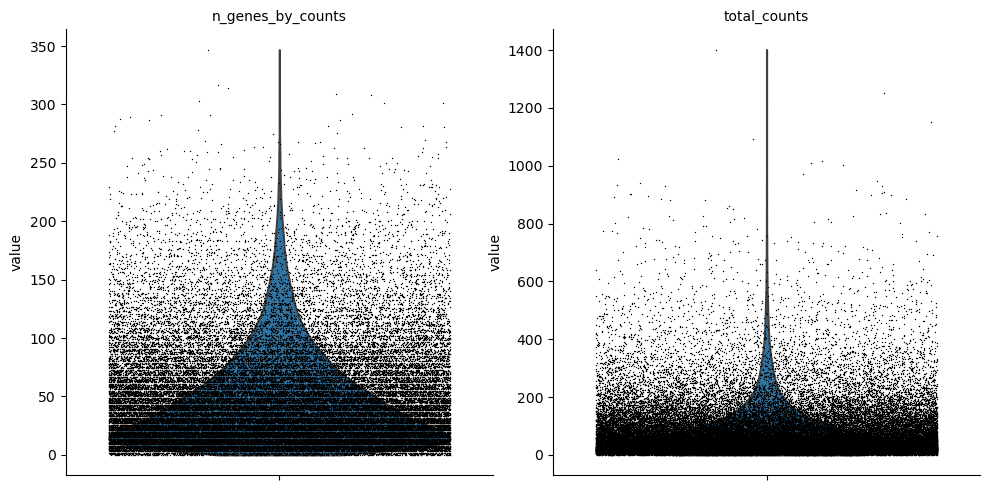

In [39]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True)

In [40]:
#plt.subplots(figsize=(2,2))
#sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Calculate quality control metrics

Plot the “total_counts” and “n_genes_by_counts” from adata.obs. The first subplot shows adata.obs["total_counts"], the second adata.obs["total_counts"] less than 10000. The third subplot displays adata.obs["n_genes_by_counts"] while the fourth displays the adata.obs["n_genes_by_counts"] less than 4000

/beegfs/scratch/tmp/ipykernel_12330/2921225750.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
/beegfs/scratch/tmp/ipykernel_12330/2921225750.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=6

<Axes: xlabel='n_genes_by_counts'>

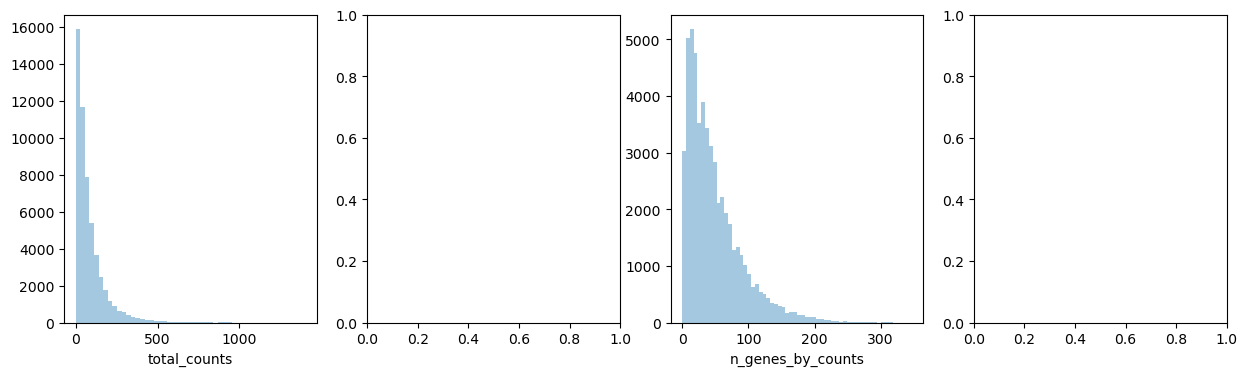

In [41]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
#sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
#sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])



Filter the cells based on the minimum number of counts required using scanpy.pp.filter_cells. Filter the genes based on the minimum number of cells required with scanpy.pp.filter_genes. The parameters for both were specified based on the plots above. They were set to filter out nearly 10% of the cells and genes with minimum counts and minimum cells respectively. It’s a conservative filtering, more relaxed ones could be also useful.

In [42]:
#sc.pp.filter_cells(adata, min_counts=100)
#sc.pp.filter_genes(adata, min_cells=400)
adata = adata[adata.obs['total_counts'] >= 20]

In [43]:
#min(adata_sub.obs.total_counts)

In [44]:
min(adata.obs.total_counts)

20

Annotate the highly variable genes based on the count data by using scanpy.pp.highly_variable_genes with flavor="seurat_v3". Normalize counts per cell using scanpy.pp.normalize_total.

Logarithmize, do principal component analysis, compute a neighborhood graph of the observations using scanpy.pp.log1p, scanpy.pp.pca and scanpy.pp.neighbors respectively.

Use scanpy.tl.umap to embed the neighborhood graph of the data and cluster the cells into subgroups employing scanpy.tl.leiden.

You may have to install scikit-misc package for highly variable genes identification.



In [45]:
adata.layers["counts"] = adata.X.copy()
#sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=4000)
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

/home/maurizio.aurora/seurat_spatial/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [46]:
adata.obs.shape

(42974, 31)

In [47]:
adata.shape

(42974, 979)

In [48]:
adata.obs['total_counts']

1_1        194
2_1         55
3_1        732
4_1        163
5_1        120
          ... 
3729_12     27
3731_12     21
3738_12     46
3745_12     32
3765_12     20
Name: total_counts, Length: 42974, dtype: int64

In [49]:
adata_sub.obs['total_counts'].mean()

104.28762268901686

In [50]:
data.obs['total_counts'].max()

NameError: name 'data' is not defined

In [ ]:
adata.obs['n_genes_by_counts'].mean()

In [ ]:
adata.obs['n_genes_by_counts'].max()

In [ ]:
list(adata.obs.columns)

Visualize annotation on UMAP and spatial coordinates

Subplot with scatter plot in UMAP (Uniform Manifold Approximation and Projection) basis. The embedded points were colored, respectively, according to the total counts, number of genes by counts and leiden clusters in each of the subplots. This gives us some idea of what the data looks like.



In [ ]:
#min(adata_sub.obs.total_counts)

sc.pl.umap(
    adata,
    color=[
        "total_counts",
        "n_genes_by_counts",
        "leiden",
    ],
    wspace=0.4,
)

Plot segmentation masks using squidpy.pl.spatial_segment. Specifically, the key library_id in adata.obs contains the same unique values contained in adata.uns["spatial"]. The "cell_ID" column is used to spot individual cells. Here, the images were colored in accordance with the intensity of the maximum pan-cytokeratin (CK) staining.

In [ ]:
sq.pl.spatial_segment(
    adata,
    color="Max.CD68",
    library_key="fov",
    seg_cell_id="cell_ID",
)

The argument library_id can also be altered to obtain specific field(s) of view.

In [ ]:
sq.pl.spatial_segment(
    adata,
    color="Max.CD68",
    library_key="fov",
    library_id=["10"],
    seg_cell_id="cell_ID",
)

There are several parameters that can be controlled. For instance, it is possible to plot segmentation masks as “contours”, in order to visualize the underlying image. The co-ordinates of the FOV can be specified using the argument crop_coord, to get the view of required section.



In [ ]:
sq.pl.spatial_segment(
    adata,
    color="Max.PanCK",
    library_key="fov",
    library_id="1",
    seg_cell_id="cell_ID",
    seg_contourpx=10,
    crop_coord=[(0, 0, 700, 700)],
)

If groups of observations are plotted (as above), it’s possible to modify whether to “visualize” the segmentation masks that do not belong to any selected group. It is set as “transparent” by default (see above) but in cases where e.g. no image is present it can be useful to visualize them nonetheless.

A scale bar can also be added, where size and pixel units must be passed. The sizes of the scalebars for these examples are not real values and are purely for visualization purposes.

In [ ]:
sq.pl.spatial_segment(
    adata,
    color="Area",
    library_key="fov",
    library_id=["1", "2"],
    seg_cell_id="cell_ID",
    seg_outline=True,
    cmap="plasma",
    img=False,
    scalebar_dx=1.0,
    scalebar_kwargs={"scale_loc": "bottom", "location": "lower right"},
)

In [ ]:
#Plot the image, with an overlay of the Leiden clusters. Use squidpy.pl.spatial_segment for the same. The image is not visualized by specifying img=False.

#One or multiple groups can also be used to overlay, by specifying the groups argument in squidpy.pl.spatial_segment as shown in the second subplot.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sq.pl.spatial_segment(
    adata,
    shape="hex",
    color="leiden",
    library_key="fov",
    library_id="10",
    seg_cell_id="cell_ID",
    img=False,
    size=60,
    ax=ax[0],
)


Computation of spatial statistics

Building the spatial neighbors graphs

Spatial graph is a graph of spatial neighbors with observations as nodes and neighborhood relations between observations as edges. We use spatial coordinates of spots/cells to identify neighbors among them. Different approaches of defining a neighborhood relation among observations are used for different types of spatial datasets. We use squidpy.gr.spatial_neighbors to compute the spatial neighbors graph. We use this function for a non-grid dataset with coord_type = 'generic'.

Depending on the coord_type, n_neighs specifies the number of neighboring tiles if coord_type='grid' and when the coord_type is not a grid, n_neighs represents the number of neighborhoods. Moreover, radius is only available when coord_type='generic'.

Alternatively, delaunay = True can be used, for a Delaunay triangulation graph. This way, we can observe the difference in using K-nearest neighbors and Delaunay triangulation. You can appreciate that the neighbor graph is different than before.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
sq.gr.spatial_neighbors(
    adata,
    n_neighs=10,
    coord_type="generic",
)
_, idx = adata.obsp["spatial_connectivities"][420, :].nonzero()
idx = np.append(idx, 420)
sq.pl.spatial_scatter(
    adata[idx, :],
    library_id="1",
    color="leiden",
    connectivity_key="spatial_connectivities",
    size=3,
    edges_width=1,
    edges_color="black",
    img=False,
    title="K-nearest neighbors",
    ax=ax[0],
)

sq.gr.spatial_neighbors(
    adata,
    n_neighs=10,
    coord_type="generic",
    delaunay=True,
)
_, idx = adata.obsp["spatial_connectivities"][420, :].nonzero()
idx = np.append(idx, 420)
sq.pl.spatial_scatter(
    adata[idx, :],
    library_id="1",
    color="leiden",
    connectivity_key="spatial_connectivities",
    size=3,
    edges_width=1,
    edges_color="black",
    img=False,
    title="Delaunay triangulation",
    ax=ax[1],
)

The function builds a spatial graph and saves its adjacency matrix adata.obsp['spatial_connectivities'] and distances to adata.obsp['spatial_distances'] by default.

In [ ]:
adata.obsp["spatial_connectivities"]

In [ ]:
adata.obsp["spatial_distances"]

In order to get all spots within a specified radius (in units of the spatial coordinates) from each spot as neighbors, the parameter radius should be used. We can observe how this plot is unlike the above one.

In [ ]:
sq.gr.spatial_neighbors(
    adata,
    radius=30,
    coord_type="generic",
)

_, idx = adata.obsp["spatial_connectivities"][420, :].nonzero()
idx = np.append(idx, 420)
sq.pl.spatial_scatter(
    adata[idx, :],
    library_id="16",
    color="leiden",
    connectivity_key="spatial_connectivities",
    size=3,
    edges_width=1,
    edges_color="black",
    img=False,
)

In [ ]:
adata.obsp["spatial_connectivities"]
adata.obsp["spatial_distances"]

In [ ]:
Compute centrality scores

This example shows how to compute centrality scores, given a spatial graph and cell type annotation.

The scores calculated are closeness centrality, degree centrality and clustering coefficient with the following properties: * closeness centrality - measure of how close the group is to other nodes. * clustering coefficient - measure of the degree to which nodes cluster together. * degree centrality - fraction of non-group members connected to group members.

All scores are descriptive statistics of the spatial graph.

This dataset contains Leiden cluster groups’ annotations in anndata.AnnData.obs, which are used for calculation of centrality scores.

First, we need to compute a connectivity matrix from spatial coordinates to calculate the centrality scores. We can use squidpy.gr.spatial_neighbors for this purpose. We use the coord_type="generic" based on the data and the neighbors are classified with Delaunay triangulation by specifying delaunay=True.



In [ ]:
adata_spatial_neighbor = sq.gr.spatial_neighbors(
    adata, coord_type="generic", delaunay=True
)

Centrality scores are calculated with squidpy.gr.centrality_scores, with the Leiden clusters.

In [ ]:
sq.gr.centrality_scores(adata, cluster_key="leiden")

The results were visualized by plotting the average centrality, closeness centrality, and degree centrality using squidpy.pl.centrality_scores.

In [ ]:
sq.pl.centrality_scores(adata, cluster_key="leiden", figsize=(10, 6))

Compute co-occurrence probability

This example shows how to compute the co-occurrence probability.

The co-occurrence score is defined as:

 
p
(
e
x
p
|
c
o
n
d
)
p
(
e
x
p
)
where 
p
(
e
x
p
|
c
o
n
d
)
 is the conditional probability of observing a cluster 
e
x
p
 conditioned on the presence of a cluster 
c
o
n
d
, whereas 
p
(
e
x
p
)
 is the probability of observing 
e
x
p
 in the radius size of interest. The score is computed across increasing radii size around each cell in the tissue.

We can compute the co-occurrence score with squidpy.gr.co_occurrence. Results of co-occurrence probability ratio can be visualized with squidpy.pl.co_occurrence. The ‘3’ in the 
 
p
(
e
x
p
|
c
o
n
d
)
p
(
e
x
p
)
 represents a Leiden clustered group.



In [ ]:
adata_subset = adata[adata.obs.fov == "16"].copy()

We can further visualize tissue organization in spatial coordinates with squidpy.pl.spatial_segment, with an overlay of the expressed genes which were colored in consonance with the Leiden clusters.

In [ ]:
sq.gr.co_occurrence(
    adata_subset,
    cluster_key="leiden",
)
sq.pl.co_occurrence(
    adata_subset,
    cluster_key="leiden",
    clusters="3",
)


sq.pl.spatial_segment(
    adata_subset,
    shape="hex",
    color="leiden",
    library_id="16",
    library_key="fov",
    seg_cell_id="cell_ID",
    img=False,
    size=60,
)

Neighbors enrichment analysis

This example shows how to run the neighbors enrichment analysis routine.

It calculates an enrichment score based on proximity on the connectivity graph of cell clusters. The number of observed events is compared against 
N
 permutations and a z-score is computed.

This dataset contains cell type annotations in anndata.Anndata.obs which are used for calculation of the neighborhood enrichment. We calculate the neighborhood enrichment score with squidpy.gr.nhood_enrichment.

In [ ]:
sq.gr.nhood_enrichment(adata, cluster_key="leiden")

The same can be done for a specific FOV, by creating a subset of the anndata.AnnData.

In [ ]:
sq.gr.nhood_enrichment(adata_subset, cluster_key="leiden")

And visualize the results with squidpy.pl.nhood_enrichment.

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(22, 22))
sq.pl.nhood_enrichment(
    adata,
    cluster_key="leiden",
    figsize=(3, 3),
    ax=ax[0],
    title="Neighborhood enrichment adata",
)
sq.pl.nhood_enrichment(
    adata_subset,
    cluster_key="leiden",
    figsize=(3, 3),
    ax=ax[1],
    title="Neighborhood enrichment adata_subset",
)
sq.pl.spatial_segment(
    adata_subset,
    shape="hex",
    color="leiden",
    library_id="16",
    library_key="fov",
    seg_cell_id="cell_ID",
    img=False,
    size=60,
    ax=ax[2],
)

Compute Ripley’s statistics

This example shows how to compute the Ripley’s L function.

The Ripley’s L function is a descriptive statistics generally used to determine whether points have a random, dispersed or clustered distribution pattern at certain scale. The Ripley’s L is a variance-normalized version of the Ripley’s K statistic. There are also 2 other Ripley’s statistics available (that are closely related): ‘G’ and ‘F’.

Ripley’s G monitors the portion of points for which the nearest neighbor is within a given distance threshold, and plots that cumulative percentage against the increasing distance radii.

For increasing separation range, Ripley’s F function assembles the percentage of points which can be found in the aforementioned range from an arbitrary point pattern spawned in the expanse of the noticed pattern.

We can compute the Ripley’s L function with squidpy.gr.ripley. Results can be visualized with squidpy.pl.ripley. The same was plotted for adata_subset. Other Ripley’s statistics can be specified using mode = 'G' or mode = 'F'.



mode = "L"
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

sq.gr.ripley(adata_subset, cluster_key="leiden", mode=mode)
sq.pl.ripley(
    adata_subset,
    cluster_key="leiden",
    mode=mode,
    ax=ax[0],
)

sq.pl.spatial_segment(
    adata_subset,
    shape="hex",
    color="leiden",
    library_id="16",
    library_key="fov",
    seg_cell_id="cell_ID",
    img=False,
    size=60,
    ax=ax[1],
)

Compute Moran’s I score

This example shows how to compute the Moran’s I global spatial auto-correlation statistics.

The Moran’s I global spatial auto-correlation statistics evaluates whether features (i.e. genes) shows a pattern that is clustered, dispersed or random in the tissue are under consideration.

We can compute the Moran’s I score with squidpy.gr.spatial_autocorr and mode = 'moran'. We first need to compute a spatial graph with squidpy.gr.spatial_neighbors. We will also subset the number of genes to evaluate.

In [ ]:
sq.gr.spatial_neighbors(adata_subset, coord_type="generic", delaunay=True)
sq.gr.spatial_autocorr(
    adata_subset,
    mode="moran",
    n_perms=100,
    n_jobs=1,
)
adata_subset.uns["moranI"].head(10)

We can visualize some of those genes with squidpy.pl.spatial_segment. We could also pass mode = 'geary' to compute a closely related auto-correlation statistic, Geary’s C. See squidpy.gr.spatial_autocorr for more information.

In [ ]:
sq.pl.spatial_segment(
    adata,
    library_id="2",
    seg_cell_id="cell_ID",
    library_key="fov",
    color=["RGS5", "XBP1", "CD68"],
    size=60,
    img=False,
)

In [ ]:
sq.pl.spatial_segment(
    adata,
    library_id="3",
    seg_cell_id="cell_ID",
    library_key="fov",
    color=["XBP1", "CD68"],
    size=60,
    img=False,
)

In [ ]:
sq.pl.spatial_segment(
    adata,
    library_id="4",
    seg_cell_id="cell_ID",
    library_key="fov",
    color=["XBP1", "CD68"],
    size=60,
    img=False,
)

In [ ]:
sq.pl.spatial_segment(
    adata,
    library_id="5",
    seg_cell_id="cell_ID",
    library_key="fov",
    color=["XBP1", "CD68"],
    size=60,
    img=False,
)

In [ ]:
sq.pl.spatial_segment(
    adata,
    library_id="6",
    seg_cell_id="cell_ID",
    library_key="fov",
    color=["XBP1", "CD68"],
    size=60,
    img=False,
)

In [ ]:
sq.pl.spatial_segment(
    adata,
    library_id="8",
    seg_cell_id="cell_ID",
    library_key="fov",
    color=["XBP1", "CD68"],
    size=60,
    img=False,
)

In [ ]:
sq.pl.spatial_segment(
    adata,
    library_id="8",
    seg_cell_id="cell_ID",
    library_key="fov",
    color=["XBP1", "CD68"],
    size=60,
    img=False,
)

In [ ]:
sq.pl.spatial_segment(
    adata,
    library_id="9",
    seg_cell_id="cell_ID",
    library_key="fov",
    color=["RGS5", "MYH11", "PECAM1"],
    size=60,
    img=False,
)

In [ ]:
sq.pl.spatial_segment(
    adata,
    library_id="10",
    seg_cell_id="cell_ID",
    library_key="fov",
    color=["CD68"],
    size=60,
    img=False,
)

In [ ]:
sq.pl.spatial_segment(
    adata,
    library_id="11",
    seg_cell_id="cell_ID",
    library_key="fov",
    color=["RGS5", "MYH11", "PECAM1"],
    size=60,
    img=False,
)

In [ ]:
sq.pl.spatial_segment(
    adata,
    seg_cell_id="cell_ID",
    library_key="fov",
    library_id="10",
    img=False,
    size=60,
    ax=ax[1],
)